In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
import spacy
import gensim
import matplotlib.pyplot as plt

import os
import csv
import time
import random
from datetime import datetime, timedelta

In [11]:
nlp = spacy.load('en_vectors_web_lg')

## Import data

Proof of concept data: Data is sentences from reviews on Yelp, IMDB, and Amazon. All sentences are labelled positive or negative--there's meant to be no neutral sentences in the data. Sentiment is binary.

In [12]:
data_dir = 'data/sentiment_sentences/'
file_names = ['amazon_cells_labelled.txt','imdb_labelled.txt','yelp_labelled.txt']

def read_data(file_name):
    return pd.read_csv(os.path.join(data_dir, file_name), sep='\t', header=None, quoting=csv.QUOTE_NONE)\
        .rename(columns={
            0: 'sentence',
            1: 'score',
        })
review_sentences = pd.concat([read_data(f) for f in file_names]).reset_index(drop=True)

In [13]:
review_sentences.head()

,sentence,score
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [14]:
review_sentences.head(1)['sentence'][0]

'So there is no way for me to plug it in here in the US unless I go by a converter.'

In [15]:
len(review_sentences)

3000

> Data set is small and we have to split to train. May not be enough to get good results. Lets find out how many words per sentence on avg...

In [16]:
clothing = pd.read_csv('data/Womens Clothing E-Commerce Reviews.csv', index_col=0)
clothing = clothing[['Review Text', 'Rating']].dropna()
len(clothing)

22641

Put data in a specific structure in case I change sources later

In [17]:
# sentiment is binary
df = pd.DataFrame(columns=['text','score'])

# df['text'] = review_sentences['sentence']
# df['score'] = review_sentences['score']


df['text'] = clothing['Review Text']
df['score'] = clothing['Rating'] >= 4

# Prep data

Clean, remove punctuation

In [18]:
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import strip_numeric, strip_punctuation, strip_multiple_whitespaces
from gensim.parsing.preprocessing import preprocess_string

# prep_filters = [strip_punctuation, strip_numeric, strip_multiple_whitespaces]
prep_filters = [strip_punctuation, strip_multiple_whitespaces]

df['clean'] = df['text'].map(lambda s: ' '.join(preprocess_string(s.lower(), prep_filters)))
# ' '.join(preprocess_string(df.head(1)['sentence'][0], prep_filters))
df.head()

,text,score,clean
0,Absolutely wonderful - silky and sexy and comf...,True,absolutely wonderful silky and sexy and comfor...
1,Love this dress! it's sooo pretty. i happene...,True,love this dress it s sooo pretty i happened to...
2,I had such high hopes for this dress and reall...,False,i had such high hopes for this dress and reall...
3,"I love, love, love this jumpsuit. it's fun, fl...",True,i love love love this jumpsuit it s fun flirty...
4,This shirt is very flattering to all due to th...,True,this shirt is very flattering to all due to th...


Create word to index mapping

In [19]:
corpus = [sent.split() for sent in df['clean']]
dct = Dictionary(corpus)

dct.filter_extremes(no_below=5)
dct.compactify()

vocab_size = len(dct)

In [20]:
# exclude words that don't exist so we don't have to think about how to embed them :)
def sent2seq(sent, dct): 
    return [idx for idx in dct.doc2idx(sent.split()) if idx != -1]

In [21]:
for i in range(5):
    sample_sentence = df['clean'][i]
    seq = sent2seq(sample_sentence, dct)
    print(seq)

[0, 4, 3, 2, 1]
[24, 14, 34, 36, 33, 17, 15, 37, 25, 16, 13, 8, 28, 41, 18, 31, 30, 8, 34, 32, 11, 32, 7, 5, 6, 24, 22, 29, 26, 19, 20, 23, 10, 21, 41, 12, 9, 38, 27, 29, 35, 40, 39, 32]
[53, 78, 55, 56, 51, 14, 70, 86, 89, 51, 26, 58, 31, 32, 75, 64, 84, 74, 52, 9, 75, 76, 75, 48, 79, 45, 66, 90, 83, 71, 32, 63, 88, 87, 20, 67, 69, 81, 54, 87, 1, 49, 65, 42, 54, 53, 85, 80, 82, 60, 72, 77, 44, 68, 61, 57, 62, 46, 50, 87, 68, 60, 73, 47, 59, 91, 43]
[24, 24, 24, 99, 34, 96, 95, 94, 93, 101, 102, 97, 100, 98, 92]
[113, 85, 108, 104, 107, 103, 109, 115, 112, 22, 102, 117, 110, 114, 76, 111, 116, 117, 105, 106, 24, 113]


In [22]:
df['seqlen'] = [len(sent2seq(s, dct)) for s in df['clean']]
df['is_valid_seq_gensim'] = df['seqlen'] > 0

In [23]:
df['seqlen'].mean(), df['seqlen'].median(), (~df['is_valid_seq_gensim']).sum()

(43.30586104854026, 42.0, 0)

> A typical sequence is about 9 words. Is this large? It seems like it may be too small given the limited number of sentences.

In [24]:
import collections 
DataDTO = collections.namedtuple('DataDTO',['x_train','y_train','l_train','x_test','y_test','l_test']) 

In [25]:
# OUTPUT_SIZE = 2
PAD_SIZE = 40 # 99th percentile (longer ones truncated)
BATCH_SIZE = 10

In [26]:
def pad(xs, pad_size=PAD_SIZE): # pass in as list, since next dim is not fixed size
    padded = np.zeros([len(xs), pad_size])
    lens = np.zeros(len(xs), dtype=np.int32)
    for i,vec in enumerate(xs): # by row
        if len(vec) > pad_size:
            vec = vec[:pad_size]
        
        padded[i,:len(vec)] = vec
        lens[i] = len(vec)
        
    return padded, lens

In [27]:
data_name = 'gensim indexes'

data, lengths = pad([sent2seq(s,dct) for s in df[df['is_valid_seq_gensim']]['clean']])
y_labels = np.array(df[df['is_valid_seq_gensim']]['score'])

print(data.shape, lengths.shape, y_labels.shape)

# do test train split
split_idxs = np.random.random(len(data)) < 0.9

x_train = data[split_idxs]
y_train = y_labels[split_idxs]
lengths_train = lengths[split_idxs]

x_test = data[~split_idxs]
y_test = y_labels[~split_idxs]
lengths_test = lengths[~split_idxs]

data_gensim_dct = DataDTO(x_train, y_train, lengths_train, x_test, y_test, lengths_test)

(22641, 40) (22641,) (22641,)


# Baseline: bag of words model with LR or NB classifier

In [28]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [29]:
bl_msk = np.random.rand(len(df)) < 0.8
bl_train_x, bl_train_y = df[bl_msk]['clean'], df[bl_msk]['score']
bl_test_x, bl_test_y   = df[~bl_msk]['clean'], df[~bl_msk]['score']

In [30]:
def tokenize_lemma(text):
    return [w.lemma_ for w in nlp(text)]

pipe = Pipeline([('tfidf', CountVectorizer(ngram_range=(1,2), tokenizer=tokenize_lemma)),
                 ('classifier', MultinomialNB())])

pipe.fit(bl_train_x, bl_train_y)
bl_pred = pipe.predict(bl_test_x)
print(classification_report(bl_test_y, bl_pred))
accuracy_score(bl_test_y, bl_pred)

              precision    recall  f1-score   support

       False       0.87      0.54      0.66      1092
        True       0.87      0.97      0.92      3480

   micro avg       0.87      0.87      0.87      4572
   macro avg       0.87      0.75      0.79      4572
weighted avg       0.87      0.87      0.86      4572



0.8694225721784777

> Since these reviews are relatively "long" (longer than a single sentence or a few words) these classic methods can give a pretty commendable performance. We will not really try to beat them by a high margin, but will simply try to match this performance while building a good, generalizable neural network model.

# Keras

> Try 
    - RMSProp, AdaGrad
    - tune learning rate
    - additional regularization
    - softsign activation function
    - Xavier weight initialization
    - more data: larger dataset, semi-supervised learning, or construct new training examples by rearranging sentences (currently have more params than training examples)
    

In [31]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.layers import SpatialDropout1D, Dropout, Conv1D, AveragePooling1D
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [32]:
tokenizer = Tokenizer(num_words=vocab_size, split=' ')
tokenizer.fit_on_texts(df['clean'])
X = tokenizer.texts_to_sequences(df['clean'])
X = pad_sequences(X)

In [33]:
x_train, x_test, y_train, y_test = train_test_split(X, df['score'], test_size = 0.30)

In [36]:
embedding_size = 10
rnn_size = 20

model = Sequential()
model.add(Embedding(vocab_size, embedding_size, 
                    input_length = X.shape[1], embeddings_initializer='glorot_normal'))
model.add(SpatialDropout1D(0.3))
# model.add(Conv1D(2*embedding_size, kernel_size = 3))
# model.add(Conv1D(2*embedding_size, kernel_size = 3))
# model.add(AveragePooling1D(4))
model.add(Bidirectional(LSTM(rnn_size, dropout=0.5, recurrent_dropout=0.3)))
# model.add(Dropout(0.2))
# model.add(Dense(rnn_size//2, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 118, 10)           49440     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 118, 10)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40)                4960      
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 82        
Total params: 54,482
Trainable params: 54,482
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
batch_size = 32
train_history = model.fit(x_train, to_categorical(y_train), 
                          batch_size=batch_size, epochs=5,
                          validation_data=(x_test, to_categorical(y_test)),
                          verbose=2)

Train on 15848 samples, validate on 6793 samples
Epoch 1/5
78s - loss: 0.4782 - acc: 0.7899 - val_loss: 0.3543 - val_acc: 0.8422
Epoch 2/5
70s - loss: 0.3550 - acc: 0.8479 - val_loss: 0.3182 - val_acc: 0.8578
Epoch 3/5
62s - loss: 0.3227 - acc: 0.8646 - val_loss: 0.3056 - val_acc: 0.8659
Epoch 4/5
65s - loss: 0.3059 - acc: 0.8728 - val_loss: 0.3023 - val_acc: 0.8769
Epoch 5/5
62s - loss: 0.2959 - acc: 0.8756 - val_loss: 0.3069 - val_acc: 0.8699


> We are managing to match baseline model performance quite quickly

In [38]:
# score,acc = model.evaluate(x_test, to_categorical(y_test), batch_size=batch_size, verbose=2)
# score,acc

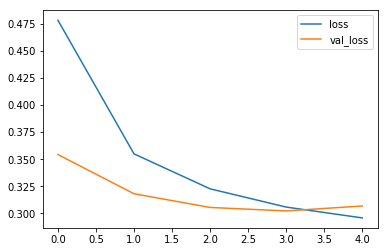

In [39]:
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.show()

> LSTM's overfit quite easily unfortunately. 

> TODO: Implement early stopping, tweak other regularizations